## Abstract

The Palmer Penguins dataset provides a set of physical characteristics of penguins of three different species: Adélie, Chinstrap, and Gentoo. Using all the physical characteristics to train a model would invariably yield highly accurate results, however, there may exist strong enough trends in the dataset to support a highly accurate model using a smaller number of features. This analysis will cover an examination of the Palmer Penguins dataset, as well as a generalizable method for determining the three strongest features for classifying the penguins. Discussion will go into strengths and weaknesses of various models and features, as well as justifying why the strongest performing model was best suited to the task at hand.

## Exploration

First, let's access the training dataset and take a look at it.

In [3]:
import pandas as pd

train_url = "https://raw.githubusercontent.com/PhilChodrow/ml-notes/main/data/palmer-penguins/train.csv"
train = pd.read_csv(train_url)
train.head()

,studyName,Sample Number,Species,Region,Island,Stage,Individual ID,Clutch Completion,Date Egg,Culmen Length (mm),Culmen Depth (mm),Flipper Length (mm),Body Mass (g),Sex,Delta 15 N (o/oo),Delta 13 C (o/oo),Comments
0,PAL0809,31,Chinstrap penguin (Pygoscelis antarctica),Anvers,Dream,"Adult, 1 Egg Stage",N63A1,Yes,11/24/08,40.9,16.6,187.0,3200.0,FEMALE,9.08458,-24.54903,NaN
1,PAL0809,41,Chinstrap penguin (Pygoscelis antarctica),Anvers,Dream,"Adult, 1 Egg Stage",N74A1,Yes,11/24/08,49.0,19.5,210.0,3950.0,MALE,9.53262,-24.66867,NaN
2,PAL0708,4,Gentoo penguin (Pygoscelis papua),Anvers,Biscoe,"Adult, 1 Egg Stage",N32A2,Yes,11/27/07,50.0,15.2,218.0,5700.0,MALE,8.25540,-25.40075,NaN
3,PAL0708,15,Gentoo penguin (Pygoscelis papua),Anvers,Biscoe,"Adult, 1 Egg Stage",N38A1,Yes,12/3/07,45.8,14.6,210.0,4200.0,FEMALE,7.79958,-25.62618,NaN
4,PAL0809,34,Chinstrap penguin (Pygoscelis antarctica),Anvers,Dream,"Adult, 1 Egg Stage",N65A2,Yes,11/24/08,51.0,18.8,203.0,4100.0,MALE,9.23196,-24.17282,NaN


In order for our models to train effectively on these features, we'll want to transform the columns to make them more machine-friendly. In particular, we will separate the species column from the rest of the data and encode species as integers (0 for Adélie, 1 for Chinstrap, and 2 for Gentoo). This will allow us to train on the data without the species labels, then check our work against the labels. We will also drop any rows with missing data so we only work with penguins for which we have complete data. Lastly, we will encode qualitative features such as the island the penguin was found on or the penguin's sex as "one-hot columns", meaning they will either be 1 for true or 0 for false.

In [33]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
le.fit(train["Species"])

def prepare_data(df):
  df = df.drop(["studyName", "Sample Number", "Individual ID", "Date Egg", "Comments", "Region"], axis = 1)
  df = df[df["Sex"] != "."]
  df = df.dropna()
  y = le.transform(df["Species"])
  df = df.drop(["Species"], axis = 1)
  df = pd.get_dummies(df, dtype=int)
  return df, y

X_train, y_train = prepare_data(train)
X_train

,Culmen Length (mm),Culmen Depth (mm),Flipper Length (mm),Body Mass (g),Delta 15 N (o/oo),Delta 13 C (o/oo),Island_Biscoe,Island_Dream,Island_Torgersen,"Stage_Adult, 1 Egg Stage",Clutch Completion_No,Clutch Completion_Yes,Sex_FEMALE,Sex_MALE
0,40.9,16.6,187.0,3200.0,9.08458,-24.54903,0,1,0,1,0,1,1,0
1,49.0,19.5,210.0,3950.0,9.53262,-24.66867,0,1,0,1,0,1,0,1
2,50.0,15.2,218.0,5700.0,8.25540,-25.40075,1,0,0,1,0,1,0,1
3,45.8,14.6,210.0,4200.0,7.79958,-25.62618,1,0,0,1,0,1,1,0
4,51.0,18.8,203.0,4100.0,9.23196,-24.17282,0,1,0,1,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
270,51.1,16.5,225.0,5250.0,8.20660,-26.36863,1,0,0,1,0,1,0,1
271,35.9,16.6,190.0,3050.0,8.47781,-26.07821,0,0,1,1,1,0,1,0
272,39.5,17.8,188.0,3300.0,9.66523,-25.06020,0,1,0,1,0,1,1,0
273,36.7,19.3,193.0,3450.0,8.76651,-25.32426,0,0,1,1,0,1,1,0


Before getting into using models for classification, it will be helpful to examine some of the features to get some preliminary ideas of what good choices for features will be. For the purposes of visualization only, we will create a dataframe containing both the features and the species of the penguins, so that we can plot them against each other. The following code block will create this dataframe, and use it to generate our first data visualization.

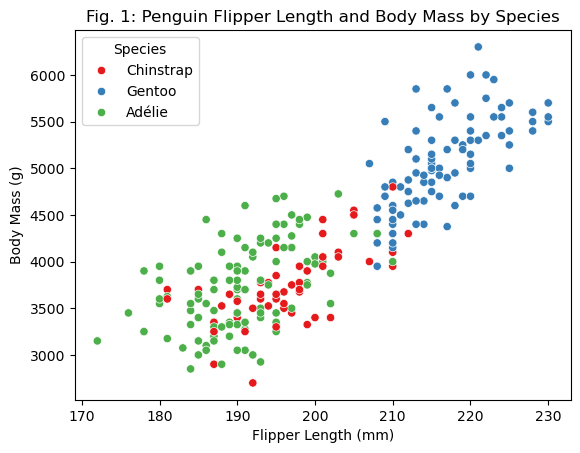

In [40]:
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt 

species_mapping = {0: "Adélie", 1: "Chinstrap", 2: "Gentoo"}
species = np.vectorize(species_mapping.get)(y_train) # Create array with species names

# Create a copy of X_train which has the species names (used only for visualizations!)
X_train_dv = X_train.copy()
X_train_dv["Species"] = species

sns.scatterplot(
    x=X_train_dv["Flipper Length (mm)"],
    y=X_train_dv["Body Mass (g)"],
    hue=X_train_dv["Species"],
    palette="Set1"
)

plt.xlabel("Flipper Length (mm)")
plt.ylabel("Body Mass (g)")
plt.title("Fig. 1: Penguin Flipper Length and Body Mass by Species")
plt.legend(title="Species")
plt.show()


Fig. 1 plots the penguins based on their body mass on the y-axis, and flipper length on the x-axis. These qualitative features seemed like a good starting point, as, together, they provide a reasonable estimate of a penguin's overall size and shape, which may be indicative of species. What's notable about this figure is that there appear to be two 'clusters': one on the lower end of the chart with a fair mix of Adélie and Chinstrap penguins, and one on the higher end with almost all Gentoo penguins. What this suggests is that these quantitative features may not be sufficient on their own to distinguish between species, as Adélie and Chinstrap penguins sit in a cluster; however, these features would be highly effective for identifying Gentoo penguins, since they have a tendency to be larger than the other types. 

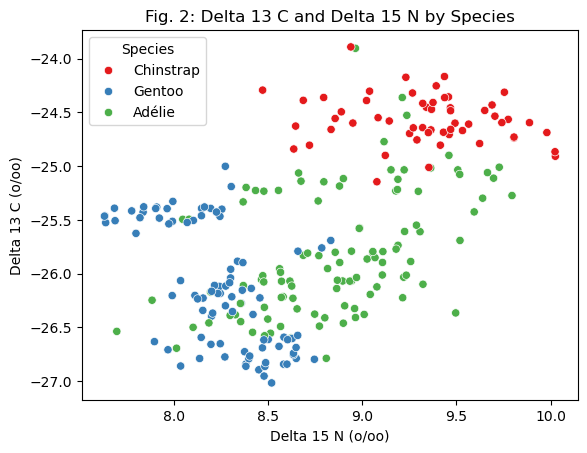

In [41]:
sns.scatterplot(
    x=X_train_dv["Delta 15 N (o/oo)"],
    y=X_train_dv["Delta 13 C (o/oo)"],
    hue=X_train_dv["Species"],
    palette="Set1"
)

plt.xlabel("Delta 15 N (o/oo)")
plt.ylabel("Delta 13 C (o/oo)")
plt.title("Fig. 2: Delta 13 C and Delta 15 N by Species")
plt.legend(title="Species")
plt.show()

Fig. 2 plots the penguins by species based on their Delta 13 C and Delta 15 N, which are measurements of the carbon isotopes and nitrogen isotopes present in the penguin's blood. The ratios of these isotopes is related to the penguin's diet, meaning it could be different between different species if they eat different types of food. The figure suggests a loose correlation within each group-- the Gentoo penguins trend towards the bottom left, the Chinstrap penguins trend towards the top right, and the Adélie penguins are somewhere in the middle. However, it is notable that Adélie penguins also appear in the Chinstrap and Gentoo clusters, meaning this quantitative feature may be effective for identifying Chinstrap and Gentoo penguins, but poor for identifying Adélie penguins. 

In [45]:
# Compute mean and median for culmen length and depth
summary_table = X_train_dv.groupby("Species").aggregate(
    Mean_Culmen_Length_mm=("Culmen Length (mm)", "mean"),
    Median_Culmen_Length_mm=("Culmen Length (mm)", "median"),
    Mean_Culmen_Depth_mm=("Culmen Depth (mm)", "mean"),
    Median_Culmen_Depth_mm=("Culmen Depth (mm)", "median")
)

# Display the table
print(summary_table)

           Mean_Culmen_Length_mm  Median_Culmen_Length_mm  \
Species                                                     
Adélie                 38.961111                    38.90   
Chinstrap              48.771429                    49.25   
Gentoo                 47.133696                    46.55   

           Mean_Culmen_Depth_mm  Median_Culmen_Depth_mm  
Species                                                  
Adélie                18.380556                   18.50  
Chinstrap             18.346429                   18.25  
Gentoo                14.926087                   14.80  


This summary table shows the mean and median values of culmen length and culmen depth by species. Adélie penguins have low average culmen lengths, and Gentoo penguins have low average culmen depths. Chinstrap penguins have high scores on both. If only one of these features were used, it would be difficult to classify all three types, as two of the species are similar on each feature individually. However, when looking at both features at the same time, the pairs of scores seem to be strong potential indicators of species. Adélie penguins should have low length but high depth, Gentoos should have high length and low depth, and Chinstraps should have both. To finish our data examination, let's now move to some qualitative features.

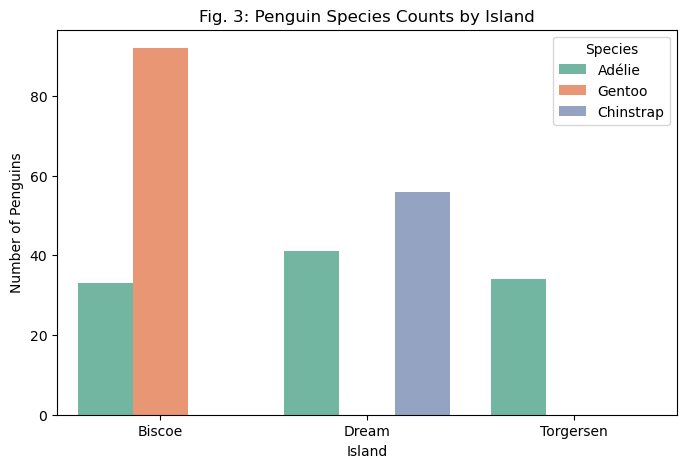

In [42]:
island_columns = ["Island_Biscoe", "Island_Dream", "Island_Torgersen"]
X_train_dv["island"] = X_train_dv[island_columns].idxmax(axis=1).str.replace("Island_", "")

# Count the number of penguins by island and species
island_species_counts = X_train_dv.groupby(["island", "Species"]).size().reset_index(name="count")

# Plot using seaborn barplot
plt.figure(figsize=(8, 5))
sns.barplot(x="island", y="count", hue="Species", data=island_species_counts, palette="Set2")

plt.xlabel("Island")
plt.ylabel("Number of Penguins")
plt.title("Fig. 3: Penguin Species Counts by Island")
plt.legend(title="Species")
plt.show()


Fig. 3 displays the species counts by island. This chart holds some initially promising results-- Gentoo penguins are only found on Biscoe Island, and Chinstrap penguins are only found on Dream island. However, there are also some problems, in that Adélie penguins are found on all three islands (though at different proportions), and, more subtly, this may suggests that the model could overfit based on these features. If, for example, the testing dataset contains a Gentoo or Chinstrap penguin found on Torgersen island, a model trained on this feature would likely predict that penguin to be Adélie (unless other features strongly suggested otherwise). Unless this subset of the dataset correctly shows that there are no Gentoo or Chinstrap penguins on Torgersen island, this pattern has the potential to yield inaccurate predictions. 

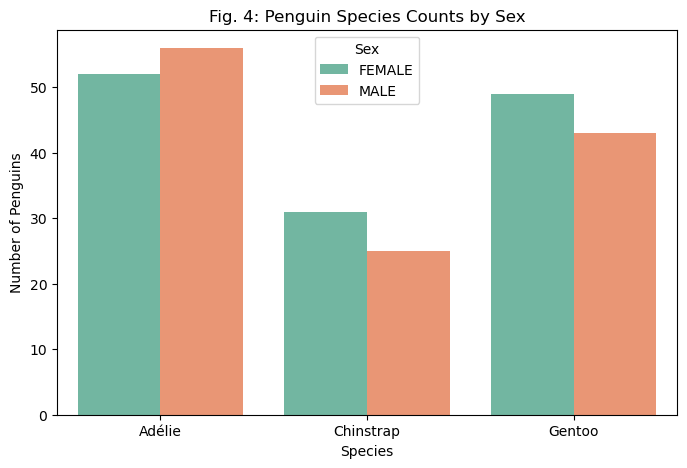

In [43]:
sex_columns = ["Sex_FEMALE", "Sex_MALE"]
X_train_dv["sex"] = X_train_dv[sex_columns].idxmax(axis=1).str.replace("Sex_", "")

# Count the number of penguins by island and species
sex_counts = X_train_dv.groupby(["sex", "Species"]).size().reset_index(name="count")

# Plot using seaborn barplot
plt.figure(figsize=(8, 5))
sns.barplot(x="Species", y="count", hue="sex", data=sex_counts, palette="Set2")

plt.xlabel("Species")
plt.ylabel("Number of Penguins")
plt.title("Fig. 4: Penguin Species Counts by Sex")
plt.legend(title="Sex")
plt.show()

Lastly, Fig. 4 shows the proportions of sex by species in the dataset. The expected rate of sex over a wide enough dataset may seem, intuitively, to be 50%, but factors such as differing behaviors between sexes may change the proportions depending on how different species operate. In this dataset, the counts within each species are relatively close, with Adélie penguins having more males than females, and the others having more females than males. Given the lack of significant variance within each species, it seems unlikely based on this visualization that sex would be a strong predictor of species.

## Modeling

Now it's time to select a model and a set of features. I experimented with several models, including the RandomForestClassifier, GaussianProcessClassifier, and Naive-Bayes classifier. All of these models performed decently, attaining maximum training accuracies in the 90+ percent range. However, what I found to be the most effective was the good old LogisticRegression. LogisticRegressions are highly effective when differences in data are linearly bound, while other models perform better on highly non-linear distinctions. Therefore, if our dataset shows linear distinctions between types, a LogisticRegression may outperform other models. Given our visualizations earlier, it was easy to see how, in some cases at least, lines could be drawn between clusters of data points of each species. This suggests that the LR model may be well suited to the task.

In terms of selecting features, the relatively modest size of the dataset allows a relatively modest search to get the job done. Simply iterating through every possible combination of two quantitative features and one qualitative feature (and keeping track of the best scoring features) will suffice in this case, though this is not a scalable method for larger datasets. The code block below implements this process, selecting two quantitative columns and one qualitative column in each iteration, then training a LogisticRegression using those features. The model is then evaluated using five-fold cross validation to ensure that it does not overfit to the training dataset. At the end, it will print what the best features were, as well as the training accuracy of the model.

The only other notable implementation here is the application of a scaler to the quantitative columns. LogisticRegressions work by finding minimum points of a function; by scaling quantitative data such that it follows a more normal distribution, this process can be carried out more efficiently and effectively. Therefore, as a final preprocessing step, we will apply a StandardScaler to the quantitative columns, which will help the LR converge in fewer iterations.

In [7]:
from itertools import combinations
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score

qual_cols = ["Clutch Completion", "Sex", "Island", "Stage_Adult, 1 Egg Stage"]
quant_cols = ['Culmen Length (mm)', 'Culmen Depth (mm)', 'Flipper Length (mm)', 'Body Mass (g)', 'Delta 15 N (o/oo)', 'Delta 13 C (o/oo)']

scaler = StandardScaler() # Scaling quantitative values decreases the num. of iterations needed for LR
X_train_scaled = X_train.copy()
X_train_scaled[quant_cols] = scaler.fit_transform(X_train[quant_cols])

best_cols = []
best_score = 0
for qual in qual_cols: 
  qual_cols = [col for col in X_train_scaled.columns if qual in col ]
  for pair in combinations(quant_cols, 2):
    cols = qual_cols + list(pair) 
    LR = LogisticRegression()
    LR.fit(X_train_scaled[cols], y_train)
    scores = cross_val_score(LR, X_train_scaled[cols], y_train, cv=5) # Using 5-fold cross validation here
    mean_score = np.mean(scores)
    if (mean_score > best_score):
      best_cols = cols
      best_score = mean_score

print(best_cols)
print(best_score)

['Sex_FEMALE', 'Sex_MALE', 'Culmen Length (mm)', 'Culmen Depth (mm)']
0.9922322775263952


The best features for the model turned out to be culmen length and culmen depth for the quantitative columns, along with sex for the qualitative column. Culmen length and culmen depth make sense, as the summary table showed that the two, when combined, could function as a very strong identifier. Sex is an unexpected result for the qualitative column, as the visualizations suggested no strong correlation between sex and species. However, it is possible that sex scored the best because it avoided overfitting to the dataset. The use of cross-validation means that overfitting will lead to poor scores, so it is possible that the other qualitative columns showed inaccurate patterns in the training data. In this case, a feature like sex which has only weak correlations could perform better than ones with misleading patterns.

## Evaluation

The iterative process yielded a training accuracy of 99.2%, which seems fairly solid. To properly evaluate it, though, we must compare it to the base rate. The following code block first uses `np.bincount` to count instances of each species in `y_train`, then computes the base rate by dividing the number of penguins in the most popular species by the total number of species. This represents the accuracy rate we would achieve if we always predicted that a penguin's species is whatever the most popular species is.

In [37]:
counts = np.bincount(y_train)
res = counts.max() / counts.sum()
print(res)

0.421875


The base rate is 42.1%, so we have significantly outperformed the base rate. Now, let's take the selected columns and evaluate the LR model on the test dataset, making sure to apply the same preprocessing steps to the test data.

In [30]:
cols = ['Culmen Length (mm)', 'Culmen Depth (mm)', 'Sex_FEMALE', 'Sex_MALE']
LR = LogisticRegression()
LR.fit(X_train_scaled[cols], y_train)

test_url = "https://raw.githubusercontent.com/PhilChodrow/ml-notes/main/data/palmer-penguins/test.csv"
test = pd.read_csv(test_url)

X_test, y_test = prepare_data(test)
X_test[quant_cols] = scaler.transform(X_test[quant_cols]) # Apply the same scaling to the test dataset!

LR.score(X_test[cols], y_test)

0.9852941176470589

The model achieves a 98.5% accuracy rate on the testing dataset, which suggests that it has generalized relatively effectively (meaning it has not overfitted to the training data set). The following code block plots the decision regions for the LR model.

In [46]:
from matplotlib.patches import Patch

def plot_regions(model, X, y):
    
    x0 = X[X.columns[0]]
    x1 = X[X.columns[1]]
    qual_features = X.columns[2:]
    
    fig, axarr = plt.subplots(1, len(qual_features), figsize = (7, 3))

    # create a grid
    grid_x = np.linspace(x0.min(),x0.max(),501)
    grid_y = np.linspace(x1.min(),x1.max(),501)
    xx, yy = np.meshgrid(grid_x, grid_y)
    
    XX = xx.ravel()
    YY = yy.ravel()

    for i in range(len(qual_features)):
      XY = pd.DataFrame({
          X.columns[0] : XX,
          X.columns[1] : YY
      })

      for j in qual_features:
        XY[j] = 0

      XY[qual_features[i]] = 1

      p = model.predict(XY)
      p = p.reshape(xx.shape)
      
      
      # use contour plot to visualize the predictions
      axarr[i].contourf(xx, yy, p, cmap = "jet", alpha = 0.2, vmin = 0, vmax = 2)
      
      ix = X[qual_features[i]] == 1
      # plot the data
      axarr[i].scatter(x0[ix], x1[ix], c = y[ix], cmap = "jet", vmin = 0, vmax = 2)
      
      axarr[i].set(xlabel = "Culmen Length (scaled)", 
            ylabel  = "Culmen Depth (scaled)", 
            title = qual_features[i])
      
      patches = []
      for color, spec in zip(["red", "green", "blue"], ["Adelie", "Chinstrap", "Gentoo"]):
        patches.append(Patch(color = color, label = spec))

      plt.legend(title = "Species", handles = patches, loc = "best")
      
      plt.tight_layout()

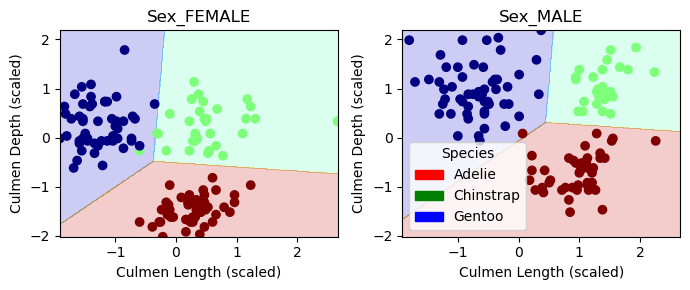

In [47]:
plot_regions(LR, X_train_scaled[cols], y_train)

The decision regions of the LR appear, on visual inspection, to be highly accurate, with one misplaced point in the Female chart and one just on the line in the Male chart. These decision regions further elucidate why sex was chosen for the qualitative feature-- it seems that males have generally larger culmens than females, which allows classifications made based on culmen length and depth to be even more accurate. To get a better idea of how the model performed on the test data, we will look at the confusion matrix. The code block below generates the confusion matrix by re-making the predictions, then comparing them to the actual test data.

In [28]:
from sklearn.metrics import confusion_matrix

y_test_pred = LR.predict(X_test[cols])
C = confusion_matrix(y_test, y_test_pred)
C

array([[31,  0,  0],
       [ 0, 10,  1],
       [ 0,  0, 26]])

In the confusion matrix above, the left column represents penguins that were classified as Adélie, the middle column represents penguins which were classified as Chinstrap, and the right column represents penguins that were classified as Gentoo. The first row were the Adélie penguins, the second row were the Chinstrap penguins, and the third row were the Gentoo penguins. What this means is that the only misclassification that the model made was classifying a single Chinstrap penguin as a Gentoo penguin. Otherwise, 31 Adélie penguins, 10 Chinstrap penguins, and 26 Gentoo penguins were correctly identified. Thinking back to the features, it makes sense that the error the model made was classifying a Chinstrap penguin as a Gentoo penguin, as the distinction between Gentoos and the other types in terms of culmen depth was a smaller distinction than the difference between, e.g. Adélie penguins and the others in terms of culmen length. If a Chinstrap penguin had a particularly low culmen depth, the model could have classified it as a Gentoo penguin.

## Discussion

In short, the strongest model I found for classifying penguins in the Palmer penguins dataset used a LogisticRegression with features of culmen length, culmen depth, and sex. While these features would have performed weakly on their own, when combined together, they formed a strong set of criteria for classification. The interplay between sex and culmen size was an interesting revelation brought about by the model, and exemplified the biggest strength of machine learning: finding unexpected patterns and using them to make highly accurate predictions. This example also exemplified the importance of simplicity in machine learning. Models like the GaussianProcessClassifier and RandomForestClassifier performed worse than the more simple LogisticRegression. When strong trends exist in datasets, we need not reinvent the wheel and overcomplicate the methods of classification. In order for the model to be generalizable to new data, it must make decisions based on logical trends, not just based on localized patterns within the training dataset.